<a href="https://colab.research.google.com/github/Inna949Festchuk/codespaces-jupyter/blob/main/quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This is a basic guide to the use of [**Remotior Sensus**
](https://fromgistors.blogspot.com/p/remotior-sensus.html).

# Install Remotior Sensus

First, we install **Remotior Sensus** using Pip.

*The dependencies (i.e. NumPy, SciPy, GDAL; optionally scikit-learn and PyTorch) are already [installed](https://remotior-sensus.readthedocs.io/en/latest/installation.html).*

In [ ]:
!pip install remotior_sensus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.8/322.8 kB 7.6 MB/s eta 0:00:00


# Start a Session of Remotior Sensus
The first step is to **start a Remotior Sensus’** [**session**](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.core.session.html). During the start of a session, a **temporary directory** is created to store temporary files, which is automatically removed after **closing the session**. Also, subprocesses are started for **parallel processing**.

Optional arguments `n_processes` and `available_ram` respectively define the number of parallel processes and the available RAM used during processing. Default is 2 parallel processes using 2048 MB of RAM.

In [ ]:
import remotior_sensus
rs = remotior_sensus.Session(n_processes=2, available_ram=10240)

For instance, check the number of parallel processes and the path of the temporary directory.

---



In [ ]:
print('parallel processes:', rs.configurations.n_processes)
print('temporary directory:', rs.configurations.temp.dir)

parallel processes: 2
temporary directory: /tmp/remotior_sensus_0813kzlu_hb6


Processing time can be reduced by increasing the **number of processes and available RAM** according to system availability. Remotior Sensus attempts to not exceed the RAM value defined with `available_ram`, however the actual RAM usage could potentially exceed this value; therefore, it is recommended to set `available_ram` as a value lower than the total RAM of the system (e.g., half of system RAM). The parameters `n_processes` and `available_ram` can also be set later.




# Manage raster bands
Although not required for processing, it is useful to create a [**BandSet**](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.core.bandset_catalog.html#remotior_sensus.core.bandset_catalog.BandSet).

A BandSet is an object that includes **information about single bands** (from the file path to the spatial and spectral characteristics). Bands in a BandSet can be referenced by the properties thereof, such as order number or center wavelength.

BandSets can be used as **input for operations** on multiple bands such as Principal Components Analysis, classification, mosaic, or band calculation. Multiple BandSets can be defined and identified by their reference number in the [**BandSet Catalog**](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.core.bandset_catalog.html#remotior_sensus.core.bandset_catalog.BandSetCatalog).



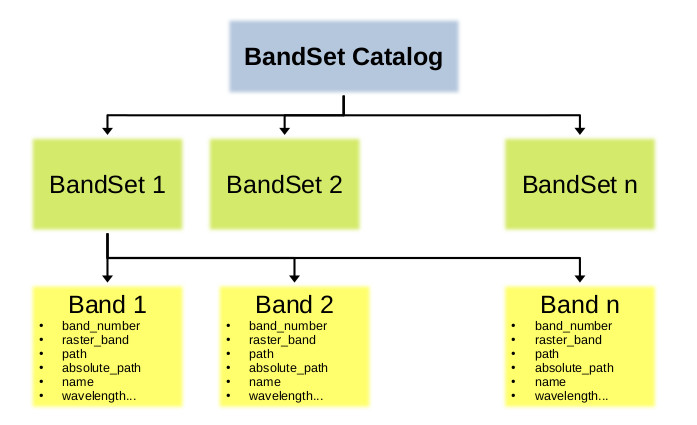

## Create a BandSet Catalog
First, initiate the **BandSet Catalog** that manages all the BandSets.

In [ ]:
catalog = rs.bandset_catalog()

We can define a working directory where to save the data of this tutorial.

In [ ]:
working_directory = '/home/tutorial'

### Sample data
The following code **downloads a sample** of Copernicus Sentinel-2 data (other tutorials describe this tool in detail).


In [ ]:
query = rs.download_products.search(product='Sentinel-2_MPC',
    date_from='2020-06-01', date_to='2020-06-30', max_cloud_cover=30,
      result_number=2, name_filter='T33SVB'
)
# select the first image
image_table = query.extra['product_table'][
    query.extra['product_table']['uid'] == query.extra['product_table'].uid[0]
    ]
sentinel2 = rs.download_products.download(
    product_table=image_table,
    output_path=working_directory,
    band_list=['02', '03', '04', '08']
)

 download products [100%] [elapsed 0min18sec]: ⬤


For the moment, we only need to know that the paths of the 4 bands are stored as a list in `sentinel2.paths`.

In [ ]:
print(sentinel2.paths)

['/home/tutorial/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_2020-06-26/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_B02.tif', '/home/tutorial/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_2020-06-26/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_B03.tif', '/home/tutorial/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_2020-06-26/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_B04.tif', '/home/tutorial/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_2020-06-26/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_B08.tif']


## Create a BandSet
Now create a BandSet defining a **path list** in `paths`.
BandSets are **ordered numerically**.
`bandset_number` explicity sets the number of the BandSet as 1.


In [ ]:
catalog.create_bandset(paths=sentinel2.paths, bandset_number=1)

For instance get BandSet **count**.

In [ ]:
print('BandSet count:', catalog.get_bandset_count())

BandSet count: 1


It is possible to **create** a BandSet from a file list, also setting the **image date** (useful because some tools allow for the selection of BandSets based on date) and the **center wavelength** (useful to select bands by wavelength in calculations).

The argument `wavelengths` accepts both a list of values, or a string defining a satellite sensor. For instance, accepted sensor names are **Landsat 8, Landsat 9, Sentinel-2**. This way, the center wavalength will be automatically **assigned based on the band nam**e.

Setting `bandset_number=1` will **replace** the existing BandSet 1.
Adding the argument `insert=True` will **add** a new BandSet at position 1, while the existing BandSets will be shifted in the order.

In [ ]:
bandset = catalog.create_bandset(
  sentinel2.paths, wavelengths=['Sentinel-2'], date='2020-06-26',
  bandset_number=1, insert=True
)

print('BandSet count:', catalog.get_bandset_count())

print('BandSet 1:', bandset)

BandSet count: 2
BandSet 1: <remotior_sensus.core.bandset_catalog.BandSet object at 0x7a949e29b1f0>


We can also get the **BandSet object** from the Catalog by the **number** thereof.

In [ ]:
bandset_1 = catalog.get_bandset(1)
print('BandSet 1:', bandset_1)

BandSet 1: <remotior_sensus.core.bandset_catalog.BandSet object at 0x7a949e29b970>


## Bands
BandSets include several information about bands, such as file path, spatial resolution, center wavelength, etc.

For example, we can get the list of file path and center wavelength of all the bands.

In [ ]:
file_paths = bandset_1.get_absolute_paths()
print('file paths: ', file_paths)

wavelengths = bandset_1.get_wavelengths()
print('center wavelengths:', wavelengths)

file paths:  ['/home/tutorial/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_2020-06-26/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_B02.tif', '/home/tutorial/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_2020-06-26/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_B03.tif', '/home/tutorial/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_2020-06-26/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_B04.tif', '/home/tutorial/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_2020-06-26/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_B08.tif']
center wavelengths: [0.49, 0.56, 0.665, 0.842]


It is possible to **get bands** directly from the BandSet Catalog.
A `Band` is a NumPy record including several fields describing the properties of the band.

For instance, get the red band from the exact value of the **attribute center wavelength** (note that `get_bandset_bands_by_attribute` returns a NumPy recarray which may contain multiple bands).

In [ ]:
bands = catalog.get_bandset_bands_by_attribute(
bandset_number=1, attribute='wavelength',
attribute_value=0.665)
# get the red band which is the only one in bands
red_band = bands[0]

print(red_band.pprint())

          band_number: 3
          raster_band: 1
                 path: /home/tutorial/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_2020-06-26/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_B04.tif
       root_directory: None
                 name: S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_B04
           wavelength: 0.665
      wavelength_unit: µm (1 E-6m)
      additive_factor: 0.0
multiplicative_factor: 1.0
                 date: 2020-06-26
               x_size: 10.0
               y_size: 10.0
                  top: 4200000.0
                 left: 399960.0
               bottom: 4090200.0
                right: 509760.0
              x_count: 10980
              y_count: 10980
               nodata: -9223372036854775808
            data_type: UInt16
      number_of_bands: 1
         x_block_size: 512
         y_block_size: 512
                scale: 1.0
               offset: 0.0
                  crs: PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",

`band_number` indicates that the band is the 4th in the BandSet.
`absolute_path` is the file path, while `path` would be the relative path if `root_directory` was defined. Also, raster information is provided such as pixel size and coordinate reference systems.

Please note that the value `nodata: -9223372036854775808` is because the image is not preprocessed and the image NoData value is not defined.

We can also use the BandSet functions to get a band having the **nearest center wavelength to a value**.

For instance, get the near-infrared band (around 0.8 µm).

In [ ]:
nir_band = bandset_1.get_band_by_wavelength(wavelength=0.8)

print(nir_band.pprint())

          band_number: 4
          raster_band: 1
                 path: /home/tutorial/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_2020-06-26/S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_B08.tif
       root_directory: None
                 name: S2B_MSIL2A_20200626T095029_R079_T33SVB_20200824T054045_B08
           wavelength: 0.842
      wavelength_unit: µm (1 E-6m)
      additive_factor: 0.0
multiplicative_factor: 1.0
                 date: 2020-06-26
               x_size: 10.0
               y_size: 10.0
                  top: 4200000.0
                 left: 399960.0
               bottom: 4090200.0
                right: 509760.0
              x_count: 10980
              y_count: 10980
               nodata: -9223372036854775808
            data_type: UInt16
      number_of_bands: 1
         x_block_size: 512
         y_block_size: 512
                scale: 1.0
               offset: 0.0
                  crs: PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",

# Processing Example: Calculate NDVI
Several [tools](https://remotior-sensus.readthedocs.io/en/latest/api_tools.html) are available. For instance the [**band_calc**](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.tools.band_calc.html) allows for mathematical **calculations** (pixel by pixel) between bands or single band rasters. Calculation is performed by parallel processes, and a new raster file is created as output.

It is possible to perform a calculation between raster files using a custom `expression_string`. The following executes the **calculation of NDVI**. The argument `input_raster_list` defines the path of the input files, and `input_name_list` defines the variable names used in the **expression** corresponding to `input_raster_list`.
Variables in `expression_string` must be inside quotes and defined in `input_name_list`.

In [ ]:
calculation = rs.band_calc(
    input_raster_list=[nir_band.path, red_band.path],
    input_name_list=['nir', 'red'],
    expression_string='("nir" - "red") / ("nir" + "red")',
    output_path=working_directory + '/ndvi.tif'
)

 band calc [100%] [elapsed 0min34sec]: ⬤

**Parallel processes** are executed to perform the calculation. In particular, input raster (or multiple rasters) are divided into **pieces** and the minimum number of **sections** according to the number of processes and available RAM (see the following figure).
In the end, the sections are merged to create a new raster for the entire output.

The output raster can also be a **virtual raster** (.vrt), which is a file that has the same characteristics as the entire raster, but saving the time required for merging the sections in a new raster.


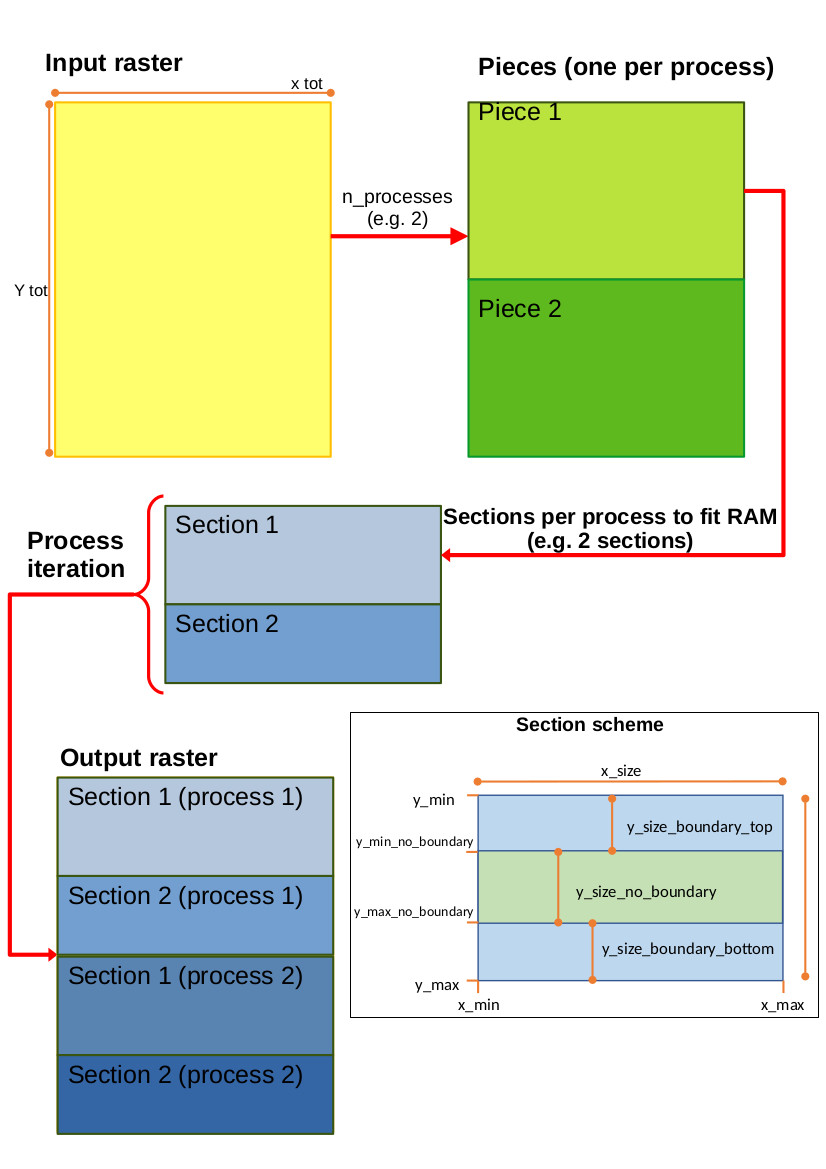

In the following example, we can **calculate NDVI** using the **band name alias** for near-infrared (`"#NIR#"`) and red (`"#RED#"`), which require band center wavelength to be properly defined in the BandSet.

`bandset_number` indicates from which BandSet the bands should be selected based on the band name alias.

Also, a **virtual raster** is created (because the `output_path` is a file having extension `.vrt`).

In [ ]:
calculation = rs.band_calc(
    expression_string='("#NIR#" - "#RED#") / ("#NIR#" + "#RED#")',
    bandset_catalog=catalog,
    output_path=working_directory + '/ndvi_virtual.vrt',
    bandset_number=1
)

 band calc [100%] [elapsed 0min20sec]: ⬤

We can notice that the last calculation using virtual raster output was more rapid than the previous one with tif output.



## Output Manager
Tools produce output files and the modules return an object [**OutputManager**](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.core.output_manager.html) having several attributes:

*   **check**: True if output is as expected, False if process failed.
*   **path**: path of the first output.
*   **paths**: list of output paths in case of multiple outputs.
*   **extra**: additional output elements depending on the process.

The previous Band calculation produced a raster output and **the path** can be retrieved as in the following example.

In [ ]:
print(calculation.path)

/home/tutorial/ndvi_virtual.vrt


We can have a look at the NDVI (using GDAL and Matplotlib).

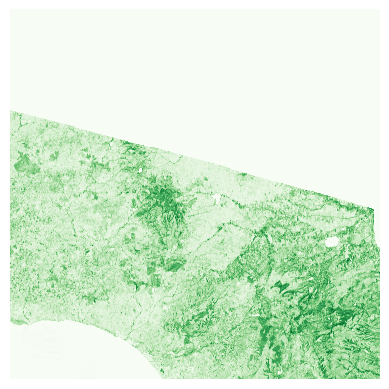

In [ ]:
from osgeo import gdal
import matplotlib.pyplot as plt

image = gdal.Open(calculation.path)
band = image.GetRasterBand(1).ReadAsArray()
plt.imshow(band, cmap='Greens', vmin=0, vmax=1)
plt.rcParams['figure.figsize'] = (15, 15)
plt.axis('off')
plt.show()
band = image = plt = None

# Processing Example: Reclassification

[**Raster reclassification**](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.tools.raster_reclassification.html) allows for the reclassification of a raster based on a reclassification table.

For instance, we can reclassify the NDVI based on a threshold (e.g. 0.3).

`reclassification_table` can be a csv file or a list of lists such as:

`[[old_value, new_value], [old_value, new_value], ...]`


The string `raster` can be used as variable defining a conditional expression in `old_value` reffered to pixel values.
For example, using the expression `['raster < 0.3', 1]` , raster values lower than 0.3 are reclassified as 1.

In [ ]:
reclassification = rs.raster_reclassification(
    raster_path=calculation.path,
    output_path=working_directory + '/reclassification.tif',
    reclassification_table=[['raster < 0.3', 1], ['raster >= 0.3', 2]]
)

 raster reclassification [100%] [elapsed 0min20sec]: ⬤

We can have a look at the result (using GDAL and Matplotlib).

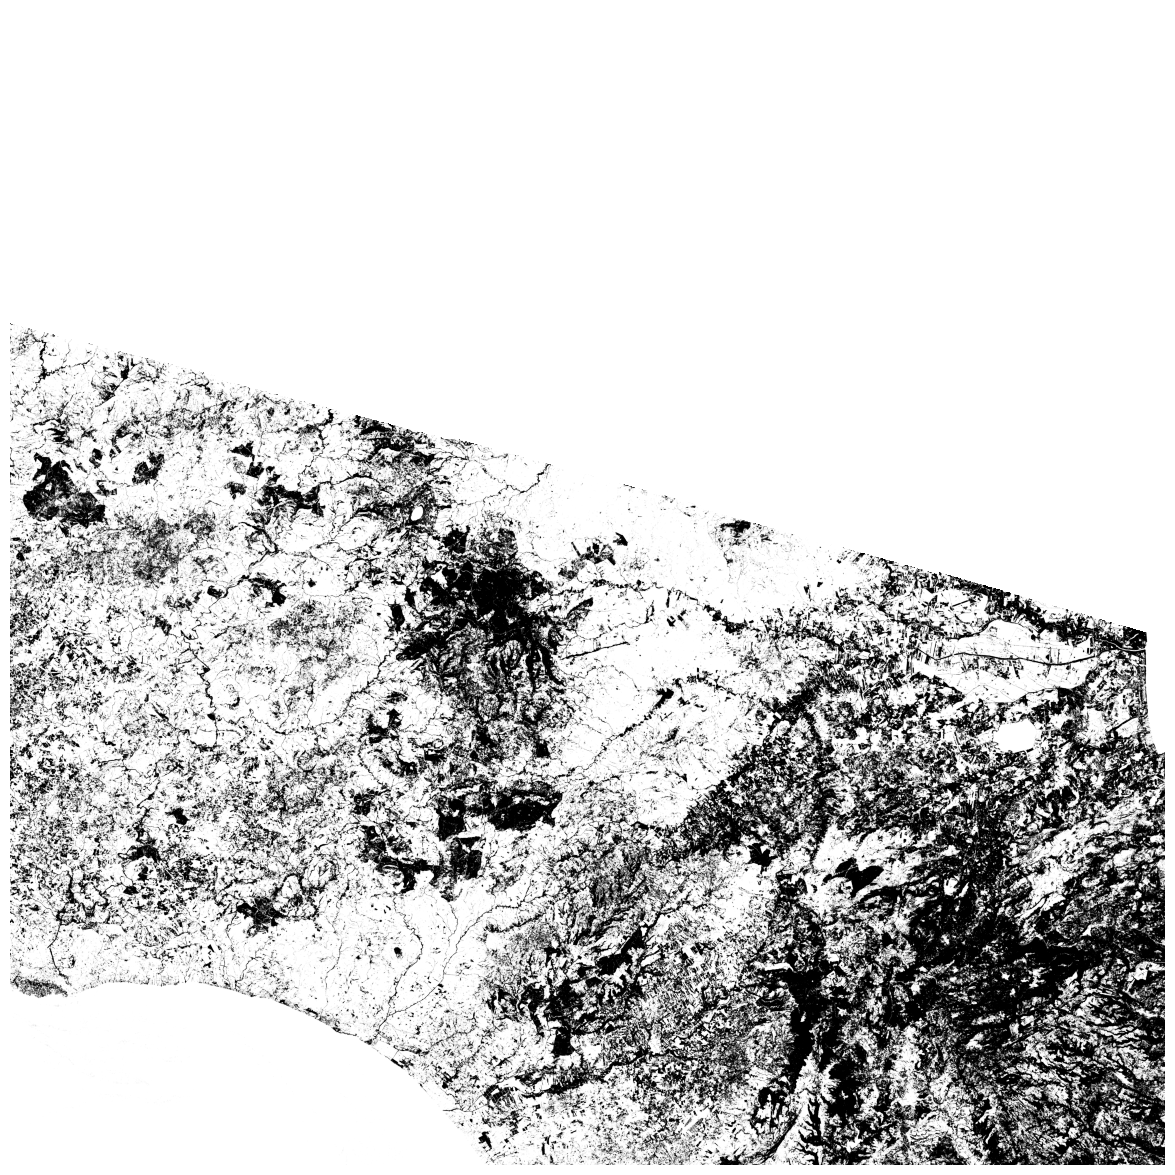

In [ ]:
from osgeo import gdal
import matplotlib.pyplot as plt

image = gdal.Open(reclassification.path)
band = image.GetRasterBand(1).ReadAsArray()
plt.imshow(band, cmap='Greys', vmin=1, vmax=2)
plt.rcParams['figure.figsize'] = (15, 15)
plt.axis('off')
plt.show()
band = image = plt = None

# Processing Example: Raster Report

[**Raster report**](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.tools.raster_report.html) allows for the calculation of a **report** providing information extracted from a raster.


For instance, we can have a report for the reclassification raster.

In [ ]:
report = rs.raster_report(
    raster_path=reclassification.path,
     output_path=working_directory + '/report.csv'
     )

 raster report [100%] [elapsed 0min11sec]: ⬤

## Table Manager
Considering that several tools produce tables, the functions in [Table Manager](https://remotior-sensus.readthedocs.io/en/latest/remotior_sensus.core.table_manager.html) allow for opening .csv and .dbf file, and **managing table data** as NumPy structured arrays.

In [ ]:
table = rs.table_manager.open_file(
    report.path, field_names=['raster_value', 'pixel_sum', 'percentage', 'area']
)

 open_csv [100%] [elapsed 0min00sec]: ⬤

The opened table is a NumPy recarray.
For example we can display the values of each row.

In [ ]:
for i in range(0, table.shape[0]):
  print('row', str(i))
  print(table[i].pprint(), end='\n\n')

row 0
raster_value: 1
   pixel_sum: 45468353
  percentage: 63.25
        area: 4546835300

row 1
raster_value: 2
   pixel_sum: 26416763
  percentage: 36.75
        area: 2641676300



Table manager includes functions for **field calculation, join and pivot tables**.

It is possible to perform a calculation on fields by defining an **expression** which includes the **field names**.

For instance, calculate the area in hectares from the field `"area"` which is $m^2$.
The argument `matrix` requires an input recarray; in `expression_string` the field names must be between quotes, and the output calculation will be performed for each row in the field defined with `output_field_name`.




In [ ]:
calculation = rs.table_manager.calculate(
    matrix=table,
    expression_string='"area" / 10000',
    output_field_name='hectares'
)

 calculate [100%]: ⬤

`calculation` is a recarray including the input table and the output field.
We can have a look at this table and notice the new field `hectares`.

In [ ]:
for i in range(0, calculation.shape[0]):
  print('row', str(i))
  print(calculation[i].pprint(), end='\n\n')

row 0
raster_value: 1
   pixel_sum: 45468353
  percentage: 63.25
        area: 4546835300
    hectares: 454683.53

row 1
raster_value: 2
   pixel_sum: 26416763
  percentage: 36.75
        area: 2641676300
    hectares: 264167.63



It is possible to **export the resulting table to .csv** file, selecting fields and separators.

In [ ]:
rs.table_manager.export_table(
matrix=calculation, output_path=working_directory + '/table.csv',
fields=['raster_value', 'hectares'], separator=';', decimal_separator='.'
)

 matrix_to_csv [100%]: ⬤

# Close the Session
The session should be closed at the end of all the processes to **remove the temporary files and stop subprocesses**.

In [ ]:
rs.close()